In [8]:
import numpy as np
import cv2
import glob
import time
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

### Extract features
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    ch1_hist = np.histogram(img[:,:,0], bins=nbins)
    ch2_hist = np.histogram(img[:,:,1], bins=nbins)
    ch3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((ch1_hist[0], ch2_hist[0], ch3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Extract features from a single image
def extract_sig_features(img, spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion
    feature_image = convert_color(img)
    #3) Compute spatial features if flag is set
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    #4) Append features to list
    img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    hist_features = color_hist(feature_image, nbins=hist_bins)
    #6) Append features to list
    img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    hog1 = get_hog_features(feature_image[:,:,0], 
                            orient, pix_per_cell, cell_per_block)
    hog2 = get_hog_features(feature_image[:,:,1], 
                            orient, pix_per_cell, cell_per_block)
    hog3 = get_hog_features(feature_image[:,:,2], 
                            orient, pix_per_cell, cell_per_block)

    #8) Append features to list
    img_features.append(hog1)
    img_features.append(hog2)
    img_features.append(hog3)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

def extract_features(cars, notcars, flip=False):
    fcars = []
    for f in cars:
        img = cv2.imread(f).astype(np.float32)/255 # Convert to (0, 1)
        fcars.append(extract_sig_features(img))
        # Flip
        if flip == True:
            fcars.append(extract_sig_features(cv2.flip(img, 1)))
    fncars = []
    for f in notcars:
        img = cv2.imread(f).astype(np.float32)/255 # Convert to (0, 1)
        fncars.append(extract_sig_features(img))
        # Flip
        if flip == True:
            fncars.append(extract_sig_features(cv2.flip(img, 1)))
    return np.vstack((fcars, fncars)).astype(np.float64), \
            np.hstack((np.ones(len(fcars)), np.zeros(len(fncars))))
        
class CarSVC():
    
    def __init__(self):
        # Create a linear SVM as classifier
        self.svc = None
        self.X_scaler = StandardScaler()
        
    ### Prepare train and test data
    def _get_cars(self):
        kit = glob.glob('datasets/vehicles/*/*.png')
        return kit
    
    def _get_notcars(self):
        ext = glob.glob('datasets/non-vehicles/*/*.png')
        return ext

    def train(self):
        cars = self._get_cars()
        notcars = self._get_notcars()
        print( 'Number of cars: {}, Number of not-cars: {}'.format( len(cars), len(notcars) ) )
        
        # Extract features and labels
        print('# Extracting...')
        X, y = extract_features(cars, notcars)
        print('# Extract done!')
        
        ### Normalize                       
        # Fit a per-column scaler
        self.X_scaler.fit(X)
        # Apply the scaler to X
        scaled_X = self.X_scaler.transform(X)

        # Split up data into randomized training and test sets
        rand_state = np.random.randint(0, 100)
        X_train, X_test, y_train, y_test = train_test_split(
                    scaled_X, y, test_size=0.2, random_state=rand_state)

        # Train
        print('# Training...')
        t = time.time()
        #params = {'kernel': ['linear'], 'C': [1, 10]} 
        #self.svc = GridSearchCV(SVC(), params).fit( X_train, y_train )
        self.svc = LinearSVC().fit( X_train, y_train )
        t2 = time.time()
        print( round( t2 - t, 2 ), 'Seconds to train SVC...' )
        print( 'SVC best params:', self.svc.best_params_ )
        
        # Test
        print('Test Accuracy of SVC = ', round(self.svc.score(X_test, y_test), 4))

In [9]:
clf = CarSVC()
clf.train()

Number of cars: 8792, Number of not-cars: 8968
# Extracting...
# Extract done!
# Training...
1070.41 Seconds to train SVC...
SVC best params: {'kernel': 'linear', 'C': 1}
Test Accuracy of SVC =  0.9918


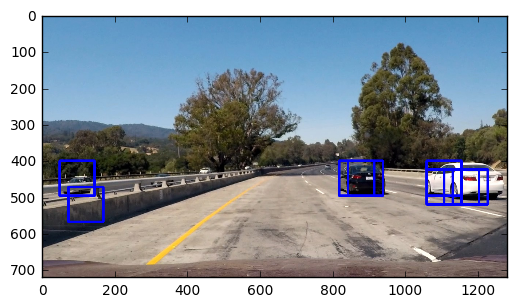

In [24]:
class CarFinder():
    
    def __init__(self, clf):
        self.clf = clf
        self.bboxs = []

    # Define a single function that can extract features using hog sub-sampling and make predictions
    def find_cars(self, img, ystart, ystop, scale, \
                  orient=9, pix_per_cell=8, cell_per_block=2, spatial_size=(32, 32), hist_bins=32):
        
        svc, X_scaler = self.clf.svc, self.clf.X_scaler
        
        img = img.astype(np.float32) / 255 # Convert to (0, 1)
        img_tosearch = img[ystart:ystop,:,:]
        ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
        
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, \
                            (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) - 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - 1 
        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - 1 
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1 
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        bbox = []
        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb * cells_per_step
                xpos = xb * cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos : ypos + nblocks_per_window, xpos : xpos + nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos : ypos + nblocks_per_window, xpos : xpos + nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos : ypos + nblocks_per_window, xpos : xpos + nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos * pix_per_cell
                ytop = ypos * pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop : ytop + window, xleft : xleft + window], (64,64))

                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(
                    np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft * scale)
                    ytop_draw = np.int(ytop * scale)
                    win_draw = np.int(window * scale)
                    bbox.append( ( (xbox_left, ytop_draw + ystart),
                                  (xbox_left + win_draw, ytop_draw + win_draw + ystart) ) )
                    #cv2.rectangle(draw_img, (xbox_left, ytop_draw + ystart),
                    #              (xbox_left + win_draw, ytop_draw + win_draw + ystart),
                    #              (0,0,255), 6)

        return bbox
    
    def draw_cars(self, img, bbox):
        draw_img = np.copy(img)
        for box in bbox:
            cv2.rectangle(draw_img, box[0], box[1], (0,0,255), 6)
        return draw_img

finder = CarFinder(clf)

ystart = 400
ystop = 656
scale = 1.5

img = mpimg.imread('test_images/test1.jpg')
bbox = finder.find_cars(img, ystart, ystop, scale)
test = finder.draw_cars(img, bbox)

plt.imshow(test)

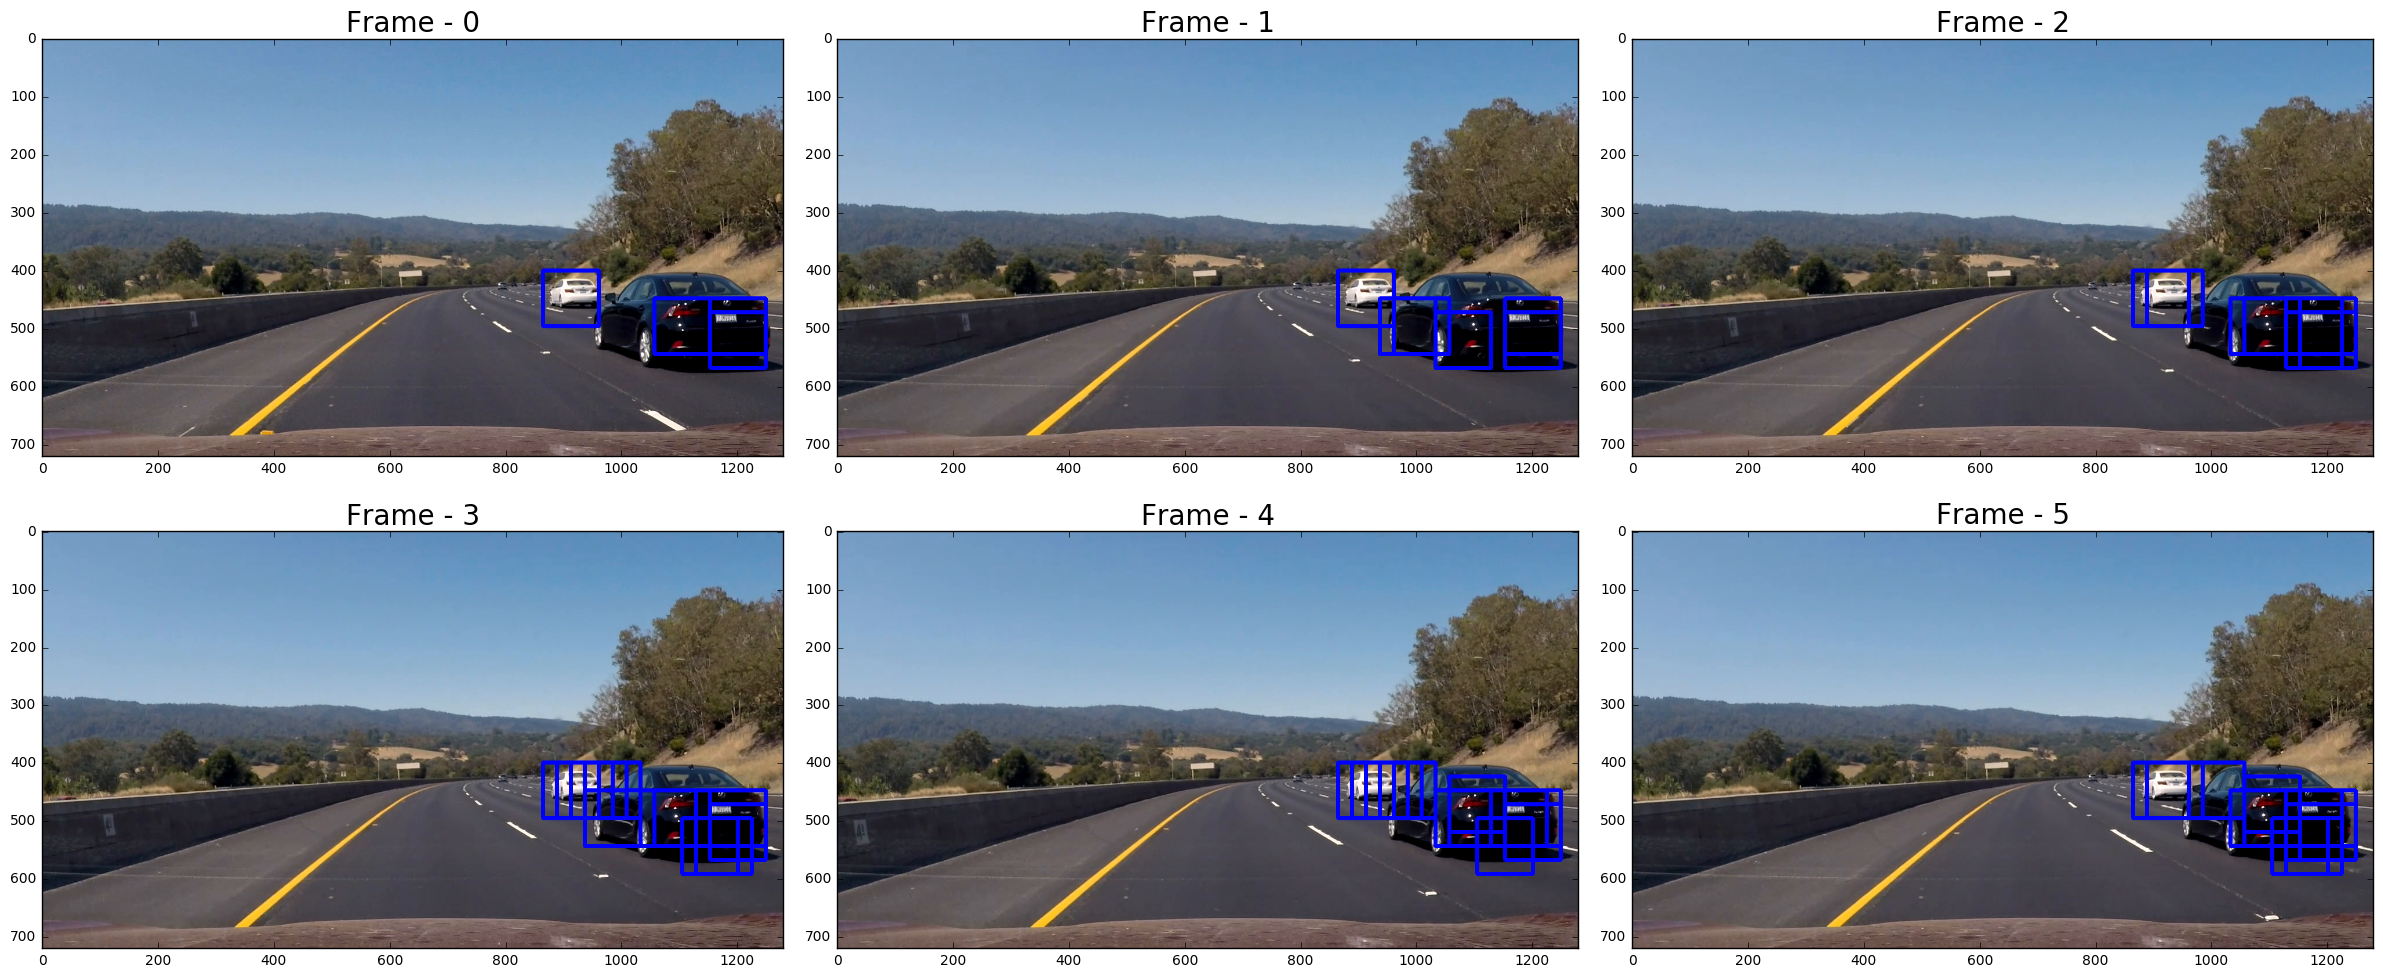

In [45]:
from moviepy.editor import VideoFileClip

clip = VideoFileClip('project_video.mp4')

frames = [frame for frame in clip.iter_frames()]

imgs = [frames[i + int(clip.fps*30)] for i in range(6)]

f, axs = plt.subplots(2, 3, figsize=(24, 10))
f.tight_layout()

for i in range( len(imgs) ):
    img = imgs[i]
    bbox = finder.find_cars(img, ystart, ystop, scale)
    cars = finder.draw_cars(img, bbox)

    ax = axs[i // 3][i % 3]
    ax.imshow(cars)
    ax.set_title('Frame - {}'.format(i), fontsize=20)
    

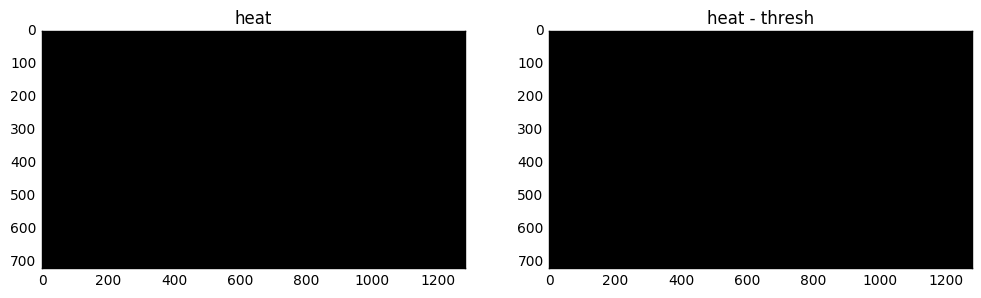

In [39]:
img = mpimg.imread('test_images/test1.jpg')
heat = np.zeros_like(img[:,:,0]).astype(np.float)

for box in bbox:
    # Add += 1 for all pixels inside each bbox
    # Assuming each "box" takes the form ((x1, y1), (x2, y2))
    heat[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

heat_thresh = np.copy(heat)
heat_thresh[heat_thresh <= 1] = 0
    
fig = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(heat, cmap='gray')
plt.title('heat')
plt.subplot(122)
plt.imshow(heat_thresh, cmap='gray')
plt.title('heat - thresh')

In [ ]:
img = mpimg.imread('test_images/test1.jpg')
test1 = finder.find_cars(img, ystart, ystop, scale)
img = mpimg.imread('test_images/test2.jpg')
test2 = finder.find_cars(img, ystart, ystop, scale)
img = mpimg.imread('test_images/test3.jpg')
test3 = finder.find_cars(img, ystart, ystop, scale)

fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(test1)
plt.title('test1')
plt.subplot(132)
plt.imshow(test2)
plt.title('test2')
plt.subplot(133)
plt.imshow(test3)
plt.title('test3')
fig.tight_layout()